## Packages and Assets

In [1]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


## Dependencies

In [3]:
model = keras.models.load_model('../../assets/deep_assets/lstm_model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           3278400   
                                                                 
 bidirectional (Bidirectiona  (None, 11, 32)           40576     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [5]:
# Load the tokenizer from the file
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

## Functions

## Loading test data

In [7]:
test_pp = pd.read_csv('../../assets/data/splits/test/preprocessed.csv')
test_pp

,title,tags,link,label
0,Além do minério de ferro: Como Vale (VALE3) ap...,"['Ações', 'BTG Pactual', 'Commodities', 'Compr...",https://www.moneytimes.com.br/alem-do-minerio-...,2
1,Santander: euforia do mercado com o banco pode...,"['Ações', 'Banco do Brasil', 'Bancos', 'BB Inv...",https://www.moneytimes.com.br/santander-eufori...,3
2,"Petrobras precifica nova emissão de US$ 1,5 bi...","['Empresas', 'Internacional', 'Petrobras', 'Re...",https://www.moneytimes.com.br/petrobras-precif...,1
3,"Petrobras vai aumentar preço da gasolina em 3,...","['Diesel', 'Empresas', 'Gasolina', 'Petrobras'...",https://www.moneytimes.com.br/petrobras-vai-au...,1
4,"Após sessão histórica, Ibovespa inicia manhã a...",['ibovespa'],https://www.sunoresearch.com.br/noticias/ibove...,0
...,...,...,...,...
1797,"Exportações da China sobem 11,4% em outubro, m...","['China', 'exportação', 'exportações da China'...",https://www.sunoresearch.com.br/noticias/expor...,0
1798,NASDAQ 100: Confira as 5 ações que mais desval...,"['cisco systems', 'lam research', 'Moderna', '...",https://www.sunoresearch.com.br/noticias/nasda...,0
1799,Petrobras prorroga até 2023 contratos com Vall...,"['Empresas', 'Minas Gerais', 'Petrobras', 'Pet...",https://www.moneytimes.com.br/petrobras-prorro...,1
1800,Cemig deve ser privatizada para deixar de ser ...,"['Cemig', 'Energia', 'Minas Gerais', 'privatiz...",https://www.sunoresearch.com.br/noticias/cemig...,0


In [8]:
X_test = test_pp.title
y_test = test_pp.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')
test_padded

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guilherme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([[2054,   15,   18, ...,  567, 9155, 1322],
       [ 108, 6002,   34, ...,    0,    0,    0],
       [   3, 1125,   44, ...,    0,    0,    0],
       ...,
       [   3, 1199,    2, ...,    0,    0,    0],
       [ 699,   53, 1903, ...,    0,    0,    0],
       [  10,  147,   11, ...,    2,    4,    0]])

### Functions

In [9]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [10]:
index_word = index2word(word_index)

In [11]:
pred_prob = model.predict(test_padded)

57/57 [==============================] - 2s 5ms/step


In [12]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [13]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[2054, 15, 18, 660, 5, 19, 4175, 11, 567, 9155...",alem minerio ferro como vale vale3 aproveita a...,"[alem, minerio, ferro, como, vale, vale3, apro...",2,2
1,"[108, 6002, 34, 36, 30, 2187, 1444]",santander euforia mercado banco pode durar pouco,"[santander, euforia, mercado, banco, pode, dur...",0,3
2,"[3, 1125, 44, 484, 2, 20, 99, 506]",petrobras precifica nova emissao <NUM> bi titu...,"[petrobras, precifica, nova, emissao, num, bi,...",1,1
3,"[3, 49, 516, 37, 42, 2, 4, 96]",petrobras vai aumentar preco gasolina <NUM> ce...,"[petrobras, vai, aumentar, preco, gasolina, nu...",1,1
4,"[14, 724, 1009, 10, 72, 1469, 390, 2, 73, 87]",apos sessao historica ibovespa inicia manha ac...,"[apos, sessao, historica, ibovespa, inicia, ma...",0,0
...,...,...,...,...,...
1797,"[598, 57, 284, 2, 4, 226, 71, 11, 88]",exportacoes china sobem <NUM> cento outubro ma...,"[exportacoes, china, sobem, num, cento, outubr...",0,0
1798,"[1705, 2, 83, 2, 8, 1829, 270]",nasdaq <NUM> confira <NUM> acoes desvalorizara...,"[nasdaq, num, confira, num, acoes, desvaloriza...",0,0
1799,"[3, 1199, 2, 409, 1, 1421, 9728]",petrobras prorroga <NUM> contratos vallourec f...,"[petrobras, prorroga, num, contratos, <OOV>, f...",1,1
1800,"[699, 53, 1903, 900, 1, 6, 1, 3455]",cemig deve privatizada deixar onus diz romeu zema,"[cemig, deve, privatizada, deixar, <OOV>, diz,...",0,0


### Metrics

In [14]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       607
           1       0.96      0.82      0.89       628
           2       0.90      0.88      0.89       367
           3       0.93      0.76      0.83       200

    accuracy                           0.87      1802
   macro avg       0.89      0.85      0.87      1802
weighted avg       0.88      0.87      0.87      1802

Confusion Matrix


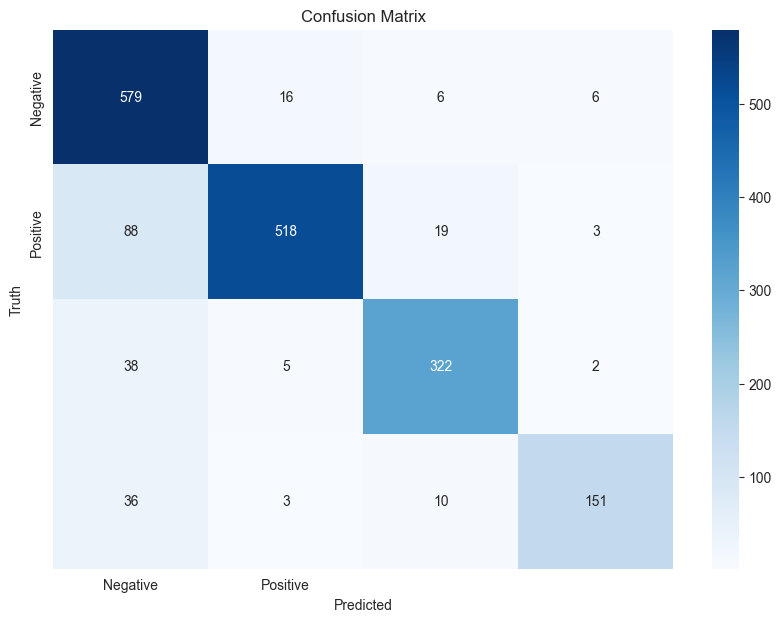

In [15]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)